In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
import shutil

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, MaxPooling2D, Flatten, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Fetching Our Data
We are using the Dataset provided by [prajnasb](https://github.com/prajnasb/observations)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
DATAPATH = '/content/drive/My Drive/Face Mask/data/'
MASKPATH = '/content/drive/My Drive/Face Mask/data/with_mask/'
NOMASKPATH = '/content/drive/My Drive/Face Mask/data/without_mask/'
TESTPATH = '/content/drive/My Drive/Face Mask/testdata'

# Visualizing our data

In [0]:
def view(pth):
    images = list()
    for img in random.sample(os.listdir(pth),9):
        images.append(img)
    i = 0
    fig,ax = plt.subplots(nrows=3, ncols=3, figsize=(30,20))
    for row in range(3):
        for col in range(3):
            ax[row,col].imshow(cv2.imread(os.path.join(pth,images[i])))
            i+=1

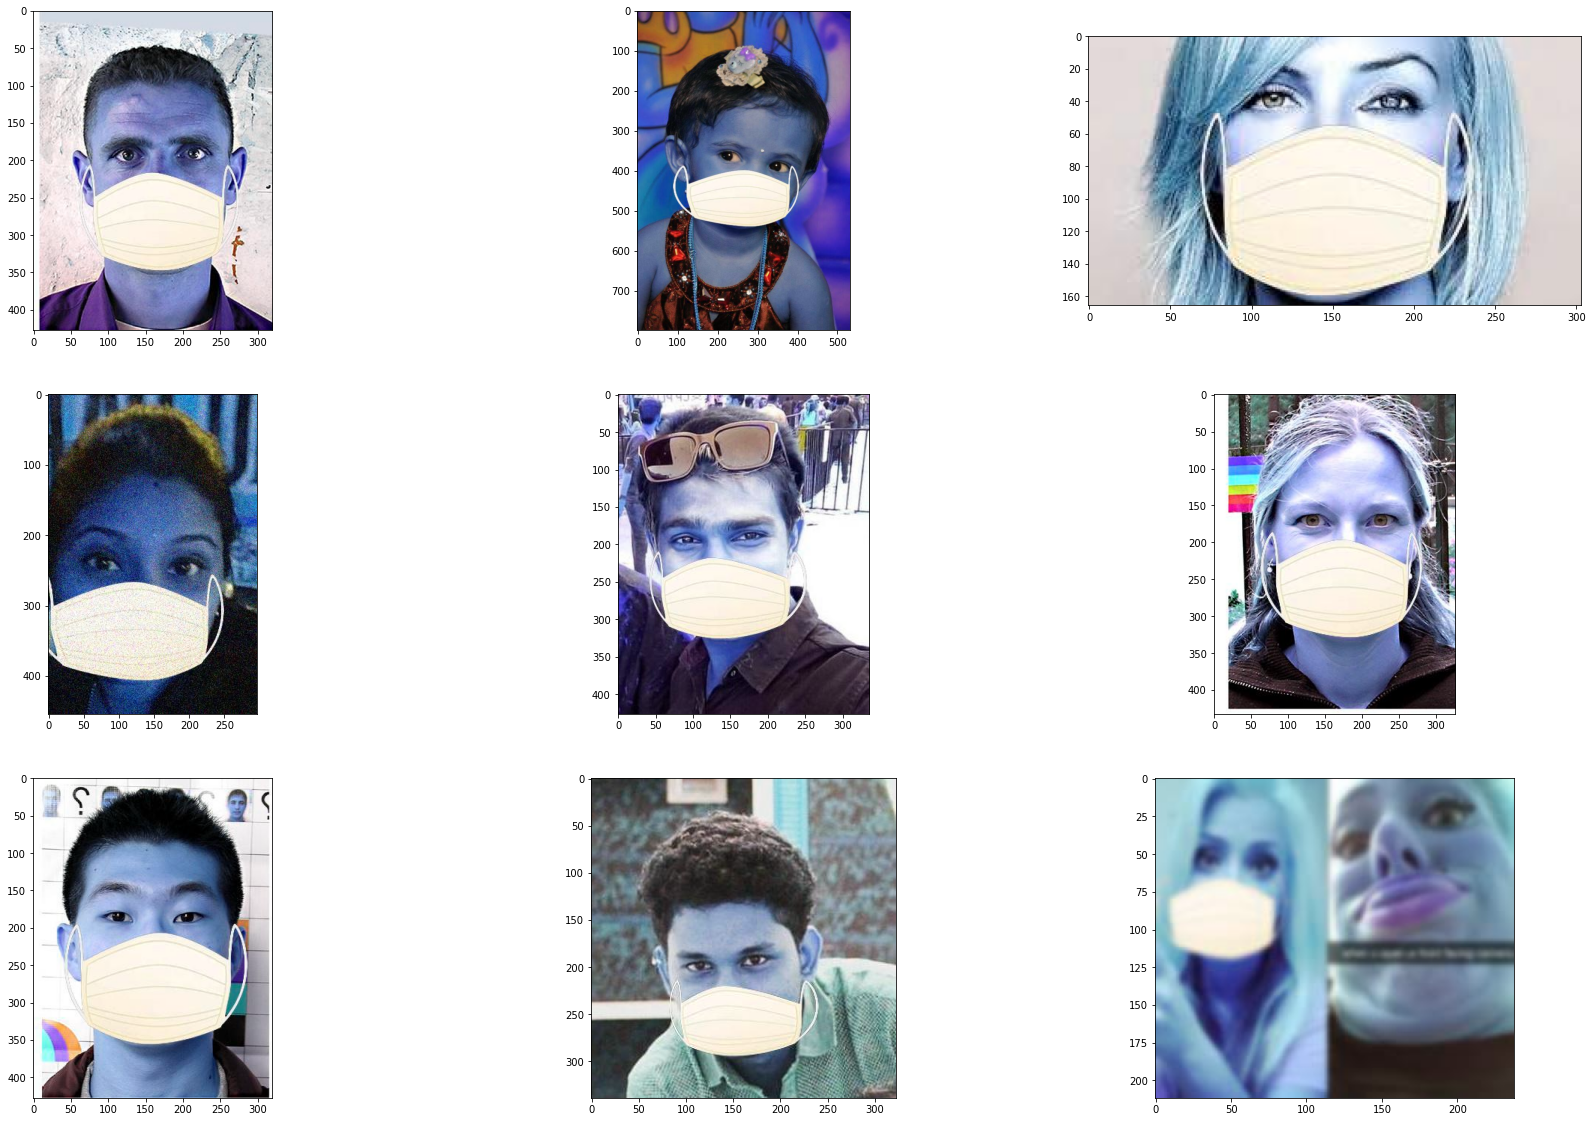

In [5]:
view(MASKPATH)

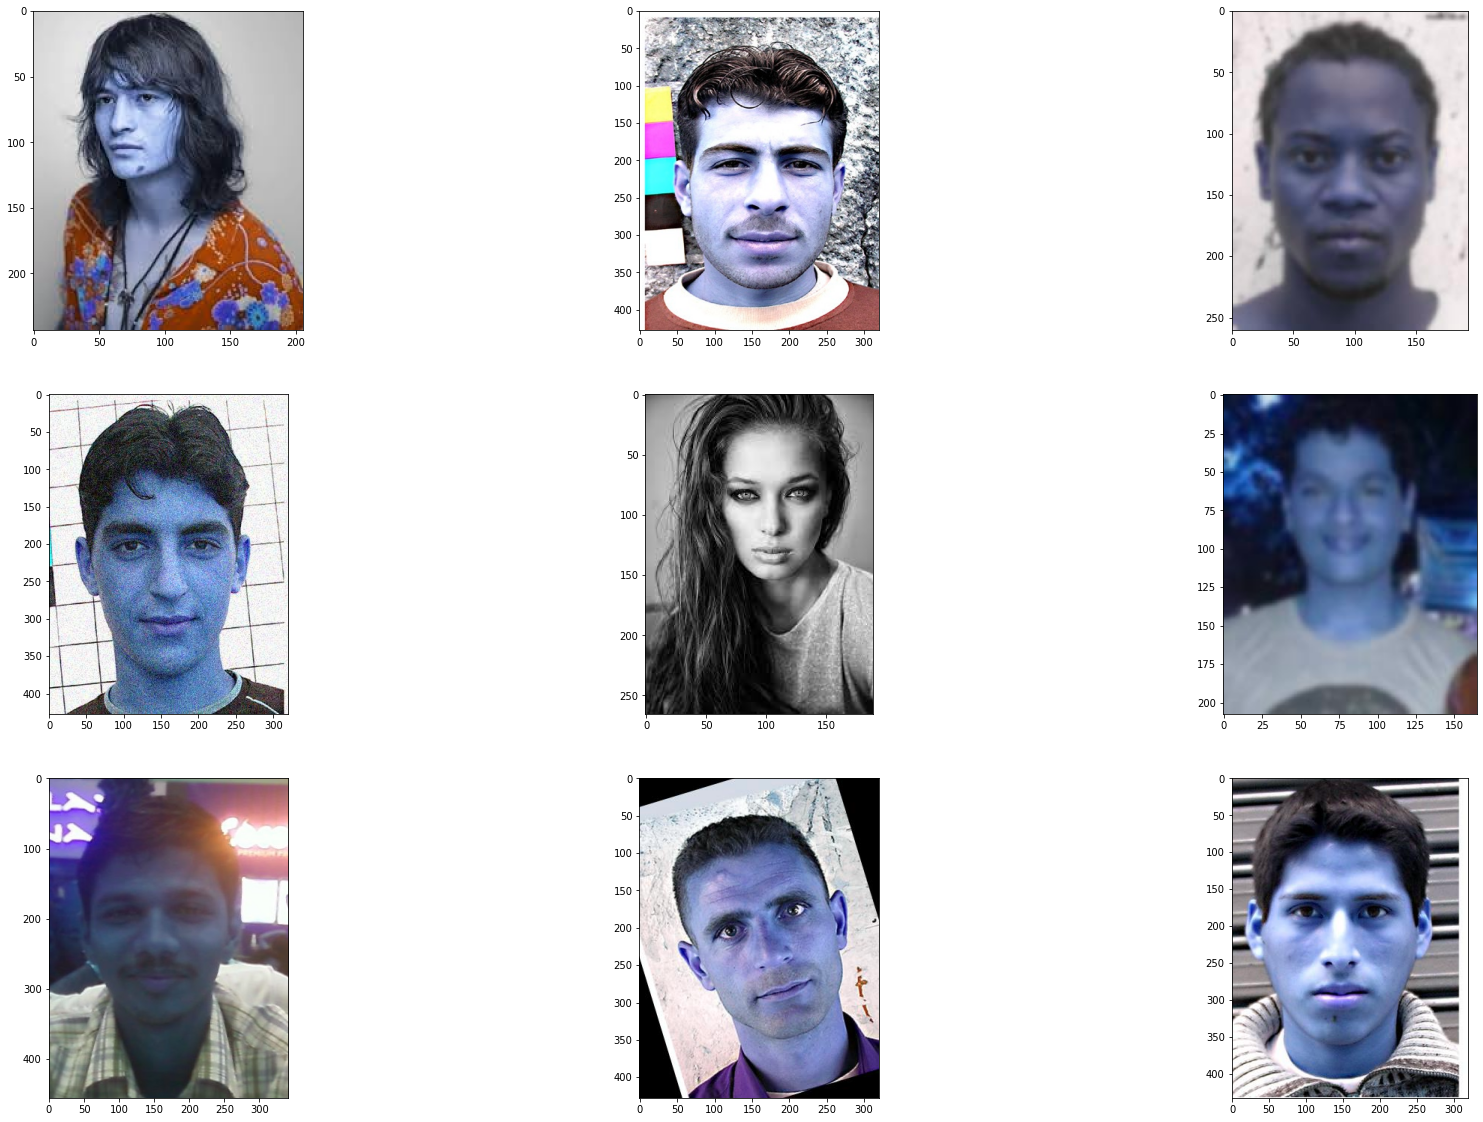

In [6]:
view(NOMASKPATH)

# Analysing our Data

In [7]:
fig = go.Figure(
    data=[go.Pie(labels=['WITHMASK','WITHOUTMASK'], 
        values=[len(os.listdir(MASKPATH)),len(os.listdir(NOMASKPATH))])
    ])
fig.show()

So clearly our Data is not highly imbalanced. So we have good data to work around with

# Splitting Training Test
We have <br>
NO MASK : 667 <br>
WITH MASK : 690 <br>
So now we split data into train test sets. We'll take around 2% data for testing purposes.


In [0]:
os.mkdir(TESTPATH)
os.mkdir(os.path.join(TESTPATH,'with_mask'))
os.mkdir(os.path.join(TESTPATH,'without_mask'))

In [0]:
def getTest(pth):
    dataSplit = int(np.ceil(len(os.listdir(pth))*0.02))
    for img in os.listdir(pth)[-dataSplit:]:
        shutil.move(os.path.join(pth,img), os.path.join('testdata'.join(pth.split('data')),img))
getTest(MASKPATH)
getTest(NOMASKPATH)

In [68]:
len(os.listdir(MASKPATH)),len(os.listdir(NOMASKPATH))

(676, 653)

In [70]:
len(os.listdir(os.path.join(TESTPATH,'with_mask'))),len(os.listdir(os.path.join(TESTPATH,'without_mask')))

(14, 14)

# Preparing Data Input Pipelines

In [0]:
BATCH_SIZE = 32

In [0]:
trainGen = ImageDataGenerator(
    rescale= 1/255.,
    horizontal_flip=True,
    validation_split = 0.1
)

testGen = ImageDataGenerator(
    rescale= 1/255.,
)

In [6]:
train = trainGen.flow_from_directory(
    DATAPATH, 
    target_size=(224, 224),
    classes=['with_mask','without_mask'],
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    subset='training'
)

validation = trainGen.flow_from_directory(
    DATAPATH, 
    target_size=(224, 224),
    classes=['with_mask','without_mask'],
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    subset='validation'
)

test = testGen.flow_from_directory(
    TESTPATH, 
    target_size=(224, 224), 
    classes=['with_mask','without_mask'],
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=True,
)

Found 1197 images belonging to 2 classes.
Found 1197 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


# Model Building

In [0]:
mob = MobileNetV2(
    input_shape = (224,224,3),
    include_top = False,
    weights = 'imagenet',
)
mob.trainable = False

In [13]:
model = Sequential()
model.add(mob)
model.add(GlobalAveragePooling2D())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                81984     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 2,340,098
Trainable params: 82,114
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
model.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['acc'])

In [0]:
checkpoint = ModelCheckpoint(
    'model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)

In [16]:
hist = model.fit(
    train,
    epochs = 15,
    validation_data = validation,
    callbacks = [checkpoint]
)

Epoch 1/15
38/38 [==============================] - ETA: 0s - loss: 0.1206 - acc: 0.9390
Epoch 00001: val_loss improved from inf to 0.00692, saving model to model.h5
38/38 [==============================] - 17s 456ms/step - loss: 0.1206 - acc: 0.9390 - val_loss: 0.0069 - val_acc: 0.9992
Epoch 2/15
38/38 [==============================] - ETA: 0s - loss: 0.0132 - acc: 0.9958
Epoch 00002: val_loss improved from 0.00692 to 0.00309, saving model to model.h5
38/38 [==============================] - 16s 431ms/step - loss: 0.0132 - acc: 0.9958 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 3/15
38/38 [==============================] - ETA: 0s - loss: 0.0058 - acc: 0.9992
Epoch 00003: val_loss improved from 0.00309 to 0.00277, saving model to model.h5
38/38 [==============================] - 16s 431ms/step - loss: 0.0058 - acc: 0.9992 - val_loss: 0.0028 - val_acc: 0.9992
Epoch 4/15
38/38 [==============================] - ETA: 0s - loss: 0.0029 - acc: 1.0000
Epoch 00004: val_loss improved from 0.0

In [12]:
model.evaluate(test)

1/1 [==============================] - 0s 1ms/step - loss: 0.0183 - acc: 1.0000


[0.018333325162529945, 1.0]